In [ ]:
# Future imports
from __future__ import annotations

# Standard library imports
import csv
import os
import sys
import warnings
from typing import Set

# Third-party imports
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import soundfile as sf
import tensorflow as tf
import torch
import whisper
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.layers import (
    Add,
    Conv1D,
    Dense,
    Dropout,
    Flatten,
    GlobalAveragePooling1D,
    Input,
    LayerNormalization,
    MultiHeadAttention,
)

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [ ]:
# Convert MP3 files from data to WAV format
# Define paths
mp3_dir = r'C:/Users/yingx/data/MEMD_audio'
wav_dir = r'C:/Users/yingx/dat/WaveFiles'

# Create output directory if it doesn't exist
os.makedirs(wav_dir, exist_ok=True)

# Process files from 2.mp3 to 2058.mp3
for i in range(2, 2059):
    mp3_path = os.path.join(mp3_dir, f'{i}.mp3')
    wav_path = os.path.join(wav_dir, f'{i}.wav')
    
    # Only process if the MP3 file exists
    if os.path.exists(mp3_path):
        try:
            # Load MP3 file with librosa (automatically converts to 22050 Hz mono)
            y, sr = librosa.load(mp3_path, sr=None)  # sr=None keeps original sample rate
            
            # Save as WAV file using soundfile
            sf.write(wav_path, y, sr)
            
            print(f'Successfully converted {i}.mp3 to {i}.wav')
        except Exception as e:
            print(f'Error processing {i}.mp3: {str(e)}')
    else:
        print(f'{i}.mp3 not found, skipping')

print('Conversion complete!')

In [ ]:
# Create features.csv from audio files in a specified directory    
wav_dir = r'C:/Users/yingx/data/WaveFiles'
output_csv = r'C:/Users/yingx/data/features.csv'

def extract_features(wav_file):
    # Load the audio file
    y, sr = librosa.load(wav_file, sr=None)

    # Calculate features
    duration = librosa.get_duration(y=y, sr=sr)
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    zero_crossing_rate = np.mean(librosa.feature.zero_crossing_rate(y=y))
    chroma_feature = np.mean(librosa.feature.chroma_stft(y=y, sr=sr), axis=1)
    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr), axis=1)
    rms = np.mean(librosa.feature.rms(y=y))
    harmonicity = np.mean(librosa.effects.harmonic(y))

    # Extract id from filename (e.g., 1 from 1.wav)
    base = os.path.basename(wav_file)
    id_str = os.path.splitext(base)[0]
    id_val = int(id_str)

    # Extract id from filename (e.g., 1 from 1.wav)
    base = os.path.basename(wav_file)
    id_str = os.path.splitext(base)[0]
    id_val = int(id_str)

    return {
        'id': id_val,
        'id': id_val,
        'duration': duration,
        'tempo': tempo,
        'spectral_centroid': spectral_centroid,
        'zero_crossing_rate': zero_crossing_rate,
        'chroma_feature': chroma_feature.tolist(),
        'mfccs': mfccs.tolist(),
        'rms': rms,
        'harmonicity': harmonicity
    }

def save_features_to_csv(features, csv_file):
    # Create a DataFrame from the features
    df = pd.DataFrame(features)

    # Ensure the directory exists
    os.makedirs(os.path.dirname(csv_file), exist_ok=True)

    # Save to CSV
    columns = ['id', 'duration', 'tempo', 'spectral_centroid', 'zero_crossing_rate', 'chroma_feature', 'mfccs', 'rms', 'harmonicity']
    df = df[columns]
    columns = ['id', 'duration', 'tempo', 'spectral_centroid', 'zero_crossing_rate', 'chroma_feature', 'mfccs', 'rms', 'harmonicity']
    df = df[columns]
    df.to_csv(csv_file, index=False)

def process_file(wav_file):
    if os.path.exists(wav_file):
        features = extract_features(wav_file)
        print(f"Processed: {wav_file}")
        return features
    else:
        print(f"File not found: {wav_file}")
        return None

def safe_extract(wav_file):
    try:
        if os.path.exists(wav_file):
            return extract_features(wav_file)
        else:
            print(f"File not found: {wav_file}")
            return None
    except Exception as e:
        print(f"Error processing {wav_file}: {e}")
        return None

if __name__ == "__main__":
    # Start from 703.wav since previous files are already processed
    wav_files = [f'{wav_dir}\\{i}.wav' for i in range(0, 2059)]
    wav_files = [f'{wav_dir}\\{i}.wav' for i in range(0, 2059)]
    os.makedirs(os.path.dirname(output_csv), exist_ok=True)

    batch_size = 100
    header_written = os.path.exists(output_csv)

    for batch_start in range(0, len(wav_files), batch_size):
        batch_files = wav_files[batch_start:batch_start + batch_size]
        with concurrent.futures.ThreadPoolExecutor() as executor:
            results = list(executor.map(safe_extract, batch_files))
        features_batch = [res for res in results if res is not None]
        if features_batch:
            df = pd.DataFrame(features_batch)
            columns = ['id', 'duration', 'tempo', 'spectral_centroid', 'zero_crossing_rate', 'chroma_feature', 'mfccs', 'rms', 'harmonicity']
            df = df[columns]
            columns = ['id', 'duration', 'tempo', 'spectral_centroid', 'zero_crossing_rate', 'chroma_feature', 'mfccs', 'rms', 'harmonicity']
            df = df[columns]
            df.to_csv(output_csv, mode='a', header=not header_written, index=False)
            header_written = True
        print(f"Processed batch {batch_start} to {batch_start + len(batch_files) - 1}")
        print(f"Processed batch {batch_start} to {batch_start + len(batch_files) - 1}")

    print(f"Feature extraction complete. Features saved to: {output_csv}")

In [ ]:
# Separate vocals from audio files using spectral masking and NN filter refinement
from vocal import spectral_masking_vocals

# Set your directories
input_directory = r'C:/Users/yingx/data/WaveFiles'
output_directory = r'C:/Users/yingx/data/Output'

def separatevocals(audiofilepath, outputpath):
    """Robust vocal separation with proper non-negative constraint handling"""
    # Load audio with error handling
    try:
        y, sr = librosa.load(audiofilepath, sr=None)
    except Exception as e:
        print(f"Error loading audio: {e}")
        return None

    # First pass: spectral masking
    try:
        vocals, background = spectral_masking_vocals(y, sr)
    except Exception as e:
        print(f"Spectral masking failed: {e}")
        return None

    # Second pass: NN filter refinement with proper non-negative handling
    try:
        # Compute STFT with safe settings
        S = librosa.stft(vocals, n_fft=2048, hop_length=512)
        S_full, phase = librosa.magphase(S)
        
        # NN filter with absolute values to ensure non-negative
        S_filter = librosa.decompose.nn_filter(np.abs(S_full),
                                              aggregate=np.median,
                                              metric='cosine',
                                              width=int(librosa.time_to_frames(2, sr=sr)))
        S_filter = np.minimum(np.abs(S_full), np.abs(S_filter))

        # Ensure non-negative inputs for softmask
        X = np.abs(S_full) - np.abs(S_filter)
        X_ref = np.abs(S_filter)
        
        # Clip to ensure non-negative (add small epsilon to avoid zeros)
        X = np.clip(X, 1e-10, None)
        X_ref = np.clip(X_ref, 1e-10, None)
        
        # Apply softmask with safe parameters
        mask_v = librosa.util.softmask(X, X_ref * 10, power=1.5)
        
        # Reconstruct audio
        vocals_clean = librosa.istft(mask_v * S_full * phase)
        
        # Post-processing
        vocals_clean = librosa.util.normalize(vocals_clean)
        if len(vocals_clean) > 0:
            vocals_clean = librosa.effects.trim(vocals_clean, top_db=25)[0]
            
    except Exception as e:
        print(f"NN filter processing failed: {e}")
        return None

    # Save output
    try:
        os.makedirs(os.path.dirname(outputpath), exist_ok=True)
        sf.write(outputpath, vocals_clean, sr)
        return True
    except Exception as e:
        print(f"Error saving output: {e}")
        return False

def process_all_files(input_dir, output_dir):
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Process files with progress bar
    successful = 0
    failed = 0
    
    for i in tqdm(range(1786, 2059)):  # from 1.wav to 2058.wav
        input_path = os.path.join(input_dir, f"{i}.wav")
        output_path = os.path.join(output_dir, f"{i}.wav")
        
        # Skip if input file doesn't exist
        if not os.path.exists(input_path):
            failed += 1
            continue
            
        # Process the file
        result = separatevocals(input_path, output_path)
        
        if result:
            successful += 1
            # Append id and filename for possible CSV output
            results.append({'id': i, 'filename': f"{i}.wav", 'status': 'success'})
        else:
            failed += 1
            results.append({'id': i, 'filename': f"{i}.wav", 'status': 'failed'})
            
    print(f"\nProcessing complete! Successful: {successful}, Failed: {failed}")

# Run the processing
process_all_files(input_directory, output_directory)

In [ ]:
# Load model - this cell only needs to be run once, model stays in memory
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

print(f"Loading Whisper model 'large' on {device} (this may take a while)...")
model = whisper.load_model("large", device=device)
print("Model loaded.")

In [ ]:
# Transcribe audio files and save to CSV
DATA_DIR = r"C:/Users/yingx/data/Output"
OUTPUT_CSV = r"C:/Users/yingx/data/transcription.csv"

def read_processed_ids(path: str) -> Set[int]:
    if not os.path.exists(path):
        return set()
    ids = set()
    try:
        with open(path, newline="", encoding="utf-8") as f:
            reader = csv.reader(f)
            header = next(reader, None)
            for row in reader:
                if not row:
                    continue
                try:
                    ids.add(int(row[0]))
                except Exception:
                    continue
    except Exception:
        return set()
    return ids

# Set parameters
START = 1
END = 2058

processed = read_processed_ids(OUTPUT_CSV)
if processed:
    print(f"Found {len(processed)} already-processed ids in {OUTPUT_CSV}; these will be skipped.")

write_header = not os.path.exists(OUTPUT_CSV)
outdir = os.path.dirname(OUTPUT_CSV)
if outdir and not os.path.exists(outdir):
    os.makedirs(outdir, exist_ok=True)

with open(OUTPUT_CSV, "a", newline="", encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    if write_header:
        writer.writerow(["id", "transcription"])

    for i in range(START, END + 1):
        if i in processed:
            continue
        
        filename = f"{i}_vocals.wav"
        path = os.path.join(DATA_DIR, filename)
        if not os.path.exists(path):
            continue

        try:
            result = model.transcribe(path)
            text = result.get("text", "").strip()
        except Exception as e:
            print(f"Error transcribing {path}: {e}")
            text = ""

        writer.writerow([i, text])
        try:
            csvfile.flush()
            os.fsync(csvfile.fileno())
        except Exception:
            pass

        if i % 100 == 0:
            print(f"Processed up to {i}")

print(f"Done. Transcriptions written (appended) to: {OUTPUT_CSV}")

In [3]:
# Clean the transcription CSV file by replacing any rows with "Thank you." with an empty string
transcription_csv = r"C:/Users/yingx/data/transcription.csv"

# Read the CSV file
df = pd.read_csv(transcription_csv)

# Replace any text that contains "Thank you." with empty string using str.contains()
df['transcription'] = df['transcription'].apply(lambda x: '' if isinstance(x, str) and 'Thank you. Thank you.' in x else x)

# Save the cleaned data back to CSV
df.to_csv(transcription_csv, index=False)
print("Transcription file cleaned successfully!")

Transcription file cleaned successfully!


In [ ]:
# Merge features.csv, transcription.csv, static_annotations_averaged_songs.csv, and emotion.csv into a singular CSV file

# Combine ststic annotations
static_annotations_df = pd.read_csv(r'C:/Users/yingx/data/annotations/annotations averaged per song/song_level/static_annotations_averaged_songs_1_2000.csv')
static_annotations2_df = pd.read_csv(r'C:/Users/yingx/data/annotations/annotations averaged per song/song_level/static_annotations_averaged_songs_2000_2058.csv')
columns_to_keep = ['id', 'valence_mean', 'valence_std', 'arousal_mean', 'arousal_std']
static_annotations_df = static_annotations_df[columns_to_keep]
static_annotations2_df = static_annotations2_df[columns_to_keep]
combined = pd.concat([static_annotations_df, static_annotations2_df], ignore_index=True)
output_path = r"C:/Users/yingx/data/static_annotations.csv"
combined.to_csv(output_path, index=False)

# Read csv
features_df = pd.read_csv(r'C:/Users/yingx/data/features.csv')
transcription_df = pd.read_csv(r'C:/Users/yingx/data/transcription.csv')
emotion_df = pd.read_csv(r'C:/Users/yingx/data/emotion.csv')

# Merge on 'id' cloumn
merged_df = features_df.merge(transcription_df, on='id', how='left') \
    .merge(combined, on='id', how='left') \
    .merge(emotion_df, on='id', how='left')

# Save the merged DataFrame to a new CSV file
merged_df.to_csv(r'C:/Users/yingx/data/merged_data.csv', index=False)
print("Data merged successfully into merged_data.csv")


In [10]:
# get train_X, train_y, Test_X 
# Load both CSV files
merged_data = pd.read_csv(r"C:\Users\yingx\data\merged_data.csv")
emotion_data = pd.read_csv(r"C:\Users\yingx\data\emotion.csv")

# Get list of ids from emotion.csv
emotion_ids = emotion_data['id']

# Select feature columns
feature_cols = [
    'id', 'duration', 'tempo', 'spectral_centroid', 'zero_crossing_rate',
    'chroma_feature', 'mfccs', 'rms', 'harmonicity', 'transcription',
    'valence_mean', 'valence_std', 'arousal_mean', 'arousal_std'
]

# train_X: rows from merged_data that have matching ids in emotion.csv
train_X = merged_data[merged_data['id'].isin(emotion_ids)][feature_cols].reset_index(drop=True)

# train_y: emotion.csv (just emotion labels)
train_y = emotion_data.reset_index(drop=True)

# test_X: rows from merged_data where id is NOT in emotion.csv
test_X = merged_data[~merged_data['id'].isin(emotion_ids)][feature_cols].reset_index(drop=True)

# Optional: check sizes
print("train_X:", train_X.shape)
print("train_y:", train_y.shape)
print("test_X:", test_X.shape)

train_X: (199, 14)
train_y: (199, 2)
test_X: (1603, 14)


In [11]:
# --- 1) Utils ---
def parse_list_string(list_str):
    """Convert '[1, 2, 3]' -> [1.0, 2.0, 3.0]; pass through if already list/np.ndarray/NaN."""
    if isinstance(list_str, str):
        s = list_str.strip()
        if s.startswith('[') and s.endswith(']'):
            items = [t.strip() for t in s[1:-1].split(',')]
            return [float(x) for x in items if x]
        # fallback: single number as string
        try:
            return [float(s)]
        except:
            return []
    if isinstance(list_str, (list, np.ndarray)):
        return [float(x) for x in list_str]
    return [] if pd.isna(list_str) else [float(list_str)]

def pad_or_trunc(x, target_len):
    """Pad with zeros or truncate to target_len."""
    x = list(x) if x is not None else []
    if len(x) >= target_len:
        return x[:target_len]
    return x + [0.0] * (target_len - len(x))

def transcription_length(val):
    if pd.isna(val):
        return 0
    return len(str(val))

# --- 2) Parse list columns safely ---
list_columns = ['chroma_feature', 'mfccs']
for df_ in (train_X, test_X):
    for col in list_columns:
        if col in df_.columns:
            df_[col] = df_[col].apply(parse_list_string)
        else:
            # ensure column exists even if missing
            df_[col] = [[] for _ in range(len(df_))]

# --- 3) Build feature vectors ---
# Fixed sizes for CNN input
CHROMA_LEN = 12
MFCC_LEN   = 13

scalar_cols = [
    'duration', 'tempo', 'spectral_centroid', 'zero_crossing_rate',
    'rms', 'harmonicity', 'valence_mean', 'valence_std',
    'arousal_mean', 'arousal_std'
]
# We'll replace raw 'transcription' with a numeric proxy:
# transcription_length = len(text)
use_transcription_length = False

def df_to_feature_matrix(df):
    # ensure all scalar cols exist
    for c in scalar_cols:
        if c not in df.columns:
            df[c] = np.nan

    # build rows
    rows = []
    ids  = []
    for _, row in df.iterrows():
        scalars = [row.get(c, np.nan) for c in scalar_cols]
        # transcription length proxy
        if use_transcription_length:
            scalars.append(transcription_length(row.get('transcription', "")))

        chroma = pad_or_trunc(row.get('chroma_feature', []), CHROMA_LEN)
        mfccs  = pad_or_trunc(row.get('mfccs', []), MFCC_LEN)

        feature_vec = scalars + chroma + mfccs
        rows.append(feature_vec)
        ids.append(row.get('id'))

    X = np.array(rows, dtype=np.float32)
    return ids, X

train_ids, X_train = df_to_feature_matrix(train_X)
test_ids,  X_test  = df_to_feature_matrix(test_X)

# --- 4) Handle missing numeric values (NaNs) before scaling ---
# Simple strategy: fill remaining NaNs with column medians computed on TRAIN ONLY
col_medians = np.nanmedian(X_train, axis=0)
# If a column is all-NaN in train, fallback to 0
col_medians = np.where(np.isnan(col_medians), 0.0, col_medians)

def nanfill_with(train_median, X):
    X = X.copy()
    # broadcast over columns
    nan_mask = np.isnan(X)
    if nan_mask.any():
        X[nan_mask] = np.take(train_median, np.where(nan_mask)[1])
    return X

X_train = nanfill_with(col_medians, X_train)
X_test  = nanfill_with(col_medians, X_test)

# --- 5) Standardize (fit on train, apply to test) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# --- 6) Reshape for 1D CNN: (samples, timesteps=n_features, channels=1) ---
X_train_cnn = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_cnn  = X_test_scaled.reshape(X_test_scaled.shape[0],  X_test_scaled.shape[1],  1)

# --- 7) Prepare labels ---
# Align y with X_train by 'id' to guarantee correct order
train_y_aligned = pd.merge(
    pd.DataFrame({'id': train_ids}),
    train_y[['id', 'emotion']],
    on='id',
    how='left'
)

label_encoder = LabelEncoder()
y_train_int = label_encoder.fit_transform(train_y_aligned['emotion'].astype(str).fillna('UNKNOWN'))
# Optional one-hot for softmax output:
y_train_onehot = to_categorical(y_train_int)

# --- 8) Outputs you'll feed your CNN ---
# X_train_cnn : np.ndarray shape (N_train, F, 1)
# y_train_int  : np.ndarray ints (class indices)
# y_train_onehot: np.ndarray one-hot (for categorical_crossentropy)
# X_test_cnn  : np.ndarray shape (N_test, F, 1)
# label_encoder.classes_ : class names in index order

print("X_train_cnn:", X_train_cnn.shape)
print("y_train_int:", y_train_int.shape, "classes:", list(label_encoder.classes_))
print("X_test_cnn :", X_test_cnn.shape)


X_train_cnn: (199, 35, 1)
y_train_int: (199,) classes: [' Anger', ' Happy', ' Relaxed', ' Sad']
X_test_cnn : (1603, 35, 1)


In [ ]:

# Transformer block
def transformer_encoder(x, d_model=64, num_heads=4, ff_dim=128, dropout=0.2):
    # Pre-norm + MHA
    h = LayerNormalization(epsilon=1e-6)(x)
    h = MultiHeadAttention(num_heads=num_heads, key_dim=d_model//num_heads, dropout=dropout)(h, h)
    h = Dropout(dropout)(h)
    x = Add()([x, h])  # residual

    # Pre-norm + FFN
    h = LayerNormalization(epsilon=1e-6)(x)
    h = Dense(ff_dim, activation="relu")(h)
    h = Dropout(dropout)(h)
    h = Dense(d_model)(h)
    x = Add()([x, h])  # residual
    return x

# ---------------------------------------------------------
# Full model: CNN front-end -> projection to d_model -> Transformer blocks -> classifier
def build_cnn_transformer(input_shape, num_classes,
                          d_model=64, num_heads=4, ff_dim=128,
                          num_transformer_blocks=2, dropout=0.2, lr=1e-3):

    inp = Input(shape=input_shape)  # (35, 1)

    # --- CNN front-end (learn short-range interactions across the 35-step sequence)
    x = Conv1D(32, kernel_size=3, padding="same", activation="relu")(inp)
    x = Conv1D(32, kernel_size=3, padding="same", activation="relu")(x)
    x = LayerNormalization(epsilon=1e-6)(x)

    # --- Project to d_model for attention (sequence length stays 35, feature dim -> d_model)
    x = Conv1D(d_model, kernel_size=1, padding="same", activation=None)(x)

    # --- Transformer encoder blocks
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, d_model=d_model, num_heads=num_heads, ff_dim=ff_dim, dropout=dropout)

    # --- Global pooling across the 35 steps (default channels_last is correct for (batch, steps, features))
    x = GlobalAveragePooling1D()(x)

    # --- MLP head
    x = Dense(128, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(dropout)(x)

    out = Dense(num_classes, activation="softmax")(x)

    model = Model(inp, out)
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    return model

# Use your prepared arrays
# X_train_cnn: (199, 35, 1)
# y_train_onehot: (199, 4)
# X_test_cnn: (1603, 35, 1)
# label_encoder: to map indices back to class names

input_shape = (X_train_cnn.shape[1], X_train_cnn.shape[2])  # (35, 1)
num_classes = y_train_onehot.shape[1]

# Split for validation
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_cnn, y_train_onehot, test_size=0.2, random_state=42, stratify=y_train_int
)

model = build_cnn_transformer(
    input_shape=input_shape,
    num_classes=num_classes,
    d_model=64,           # embedding size inside the transformer
    num_heads=4,
    ff_dim=128,
    num_transformer_blocks=2,
    dropout=0.3,
    lr=1e-3
)

model.summary()

# Optional: class weights (helpful if classes are imbalanced)
from sklearn.utils.class_weight import compute_class_weight
classes = np.arange(num_classes)
cw = compute_class_weight("balanced", classes=classes, y=y_train_int)
class_weight = {i: w for i, w in enumerate(cw)}


# Callbacks
es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-5)

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    callbacks=[es, rlr],
    class_weight=class_weight,
    verbose=1
)

# Evaluate
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation - loss: {val_loss:.4f}, acc: {val_acc:.4f}")

# Predict on test set
proba_test = model.predict(X_test_cnn)
pred_idx = np.argmax(proba_test, axis=1)
pred_labels = label_encoder.inverse_transform(pred_idx)


try:
    test_df_out = pd.DataFrame({"id": test_ids, "predicted_emotion": pred_labels})
    print(test_df_out.head())
except NameError:
    pass


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 35, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 35, 32)       128         ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 35, 32)       3104        ['conv1d[0][0]']                 
                                                                                                  
 layer_normalization (LayerNorm  (None, 35, 32)      64          ['conv1d_1[0][0]']               
 alization)                                                                                   

In [13]:
# 1) Check class balance
import numpy as np, pandas as pd
pd.Series(y_train_int).value_counts(normalize=True).rename("train class%")

# 2) Clean label whitespace and re-encode (important!)
train_y_clean = train_y.copy()
train_y_clean["emotion"] = train_y_clean["emotion"].astype(str).str.strip()
# ...then redo LabelEncoder on the cleaned column and rebuild y_train_int/onehot

# 3) Stratified split was good; also try k-fold CV for stability:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4) Confusion matrix & per-class report on the held-out set
from sklearn.metrics import classification_report, confusion_matrix
val_pred = np.argmax(model.predict(X_val), axis=1)
print(confusion_matrix(np.argmax(y_val, axis=1), val_pred))
print(classification_report(np.argmax(y_val, axis=1), val_pred, target_names=label_encoder.classes_))


2/2 [==============================] - 0s 4ms/step
[[0 3 1 0]
 [5 5 0 5]
 [0 3 0 7]
 [2 1 0 8]]
              precision    recall  f1-score   support

       Anger       0.00      0.00      0.00         4
       Happy       0.42      0.33      0.37        15
     Relaxed       0.00      0.00      0.00        10
         Sad       0.40      0.73      0.52        11

    accuracy                           0.33        40
   macro avg       0.20      0.27      0.22        40
weighted avg       0.27      0.33      0.28        40



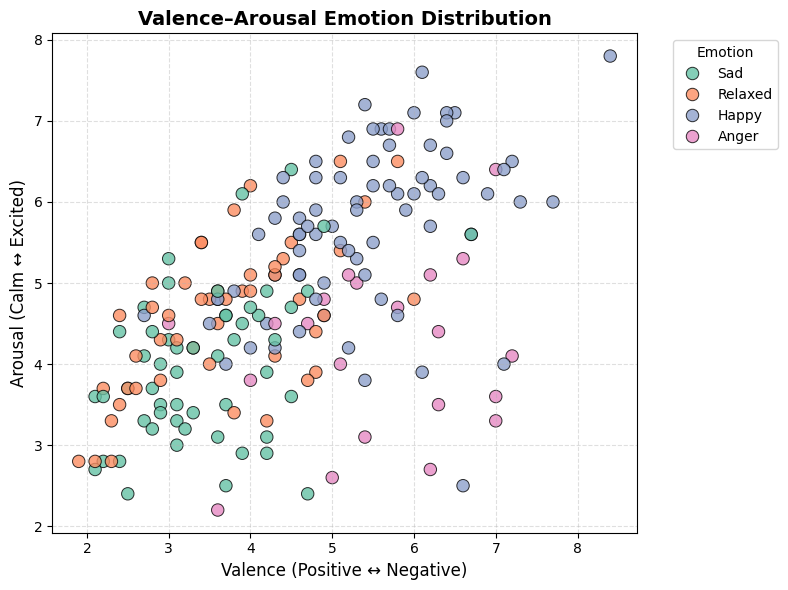

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming you have 'train_X' (features) and 'train_y' (labels) from before
# Merge valence/arousal with emotion labels
plot_df = train_X[['id', 'valence_mean', 'arousal_mean']].merge(
    train_y[['id', 'emotion']], on='id', how='left'
)

# Clean any label whitespace just in case
plot_df['emotion'] = plot_df['emotion'].astype(str).str.strip()

# --- Plot ---
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=plot_df,
    x='valence_mean',
    y='arousal_mean',
    hue='emotion',
    palette='Set2',
    s=80,
    edgecolor='k',
    alpha=0.8
)

plt.title('Valence–Arousal Emotion Distribution', fontsize=14, weight='bold')
plt.xlabel('Valence (Positive ↔ Negative)', fontsize=12)
plt.ylabel('Arousal (Calm ↔ Excited)', fontsize=12)
plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()
